O desafio foi inciado com a compreensão inicial do dataset, fazendo a leitura do documento 'Complete Case Pulp and Paper - Predictive Maintanance' e posteriormente iniciando a análise em Python

Foram organizadas as bibliotecas e o dataset importado conforme a célula a seguir:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn import ensemble, preprocessing
from sklearn.model_selection import train_test_split

train_path = r'C:\Users\felip\OneDrive\Documentos\CASE_TECNICOCIENTISTA_DE_DADOS\PM_train.txt'
test_path = r'C:\Users\felip\OneDrive\Documentos\CASE_TECNICOCIENTISTA_DE_DADOS\PM_test.txt'

df_train = pd.read_csv(train_path, header=None, sep=' ')
df_test = pd.read_csv(test_path, header=None, sep=' ')

Foi realizado o carregamento dos dados em formato ".txt". Para isso foi utilizada a biblioteca 'Pandas'. Logo na sequencia as colunas foram renomeadas conforme o documento indicava, mantendo o nome original somente nas colunas de sensores.

In [2]:
df_train.rename({0: 'asset_id',
                 1:'runtime',
                 2:'setting_1',
                 3:'setting_2',
                 4:'setting_3'},
                 axis = 1, inplace = True)

df_test.rename({0: 'asset_id',
                 1:'runtime',
                 2:'setting_1',
                 3:'setting_2',
                 4:'setting_3'},
                 axis = 1, inplace = True)

A primeira análise busca verificar quantos valores diferentes há em cada coluna, quando houver apenas 1 informação, essa coluna será excluída por falta de informação útil na análise.

In [3]:
# df_train.nunique()

Os valores únicos são excluídos

In [4]:
for col in df_train.columns:
    if len(df_train[col].unique()) == 1:
        df_train.drop(col,inplace=True,axis=1)

for col in df_test.columns:
    if len(df_test[col].unique()) == 1:
        df_test.drop(col,inplace=True,axis=1)

Visualizando novamente como o dataset está distribuido após a exclusão das colunas

In [5]:
#df_train[df_train['asset_id'] == 1].head(5)

In [6]:
# Calcula a Vida Útil Restante (RUL) para os dados de treinamento
# Encontra o último ciclo por número de unidade
max_cycle = pd.DataFrame(df_train.groupby('asset_id')['runtime'].max()).reset_index()
max_cycle.columns = ['asset_id', 'MaxOfCycle']
# Merge do ciclo máximo no dataframe 
train_merged = df_train.merge(max_cycle, left_on='asset_id', right_on='asset_id', how='inner')
# Calcula RUL para cada linha
RUL = train_merged["MaxOfCycle"] - train_merged["runtime"]
train_with_target = train_merged["RUL"] = RUL
# Remove colunas desnecessárias
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['asset_id'] == 1].head(5)

,asset_id,runtime,setting_1,setting_2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [7]:
# Define lista para colunas com dados de sensores
sensor_columns = [6,7,8,10,11,12,13,15,16,17,18,19,21,24,25]

In [8]:
# from matplotlib.pyplot import figure

# figure(figsize=(16, 12), dpi=80)

# sns.heatmap(train_with_target[sensor_columns].corr(),annot=True, cmap="Wistia")
# plt.show()

Visualização de ranking de IDs por runtime. Nesse gráfico é possível verificar quais IDs tiveram o maior ou menor tempo de duração.

In [9]:
# df_train.asset_id.value_counts().plot.bar(figsize = (20, 8))

Com o gráficos a seguir é possivel visualizar que o runtime é bastante estável até aproximadamente 100 e pratimente todos os sensores seguem uma distribuição normal, com exceção de 1, que é idenfiticado pelo índice 10. Esse aparentemente tem um valor binário.

In [10]:
# df_train.hist(bins=50, figsize=(18,16))
# plt.show()

In [11]:
# df_train['runtime'].hist(figsize=(15,6))

Os gráficos a seguir permitem identificar padrões que os sensores seguem antes da falha ocorrer

In [12]:
#Visualiza distribuição das features conforme o tempo.
#Filtrado para os 9 primeiros IDs

# explore = sns.PairGrid(data=train_with_target.query('asset_id < 9') ,
#                  x_vars= ['RUL'],
#                  y_vars= sensor_columns + ['setting_1','setting_2'],
#                  hue="asset_id", size=3, aspect=2.5)
# explore = explore.map(plt.scatter, alpha=0.5)
# explore = explore.set(xlim=(400,0))
# explore = explore.add_legend()

In [13]:
# Visualiza distribuição das features conforme o tempo.
# Filtrado para os 9 ultimos IDs

# explore = sns.PairGrid(data=train_with_target.query('asset_id > 91') ,
#                  x_vars= ['RUL'],
#                  y_vars= sensor_columns + ['setting_1','setting_2'],
#                  hue="asset_id", size=3, aspect=2.5)
# explore = explore.map(plt.scatter, alpha=0.5)
# explore = explore.set(xlim=(400,0))
# explore = explore.add_legend()

In [14]:
#Visualiza comportamento das features no tempo individualmente

# engine_id = df_train[df_train['asset_id'] == 1]
# engine_id[df_train.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30))

No gráfico a seguir é possível verificar que há tendencias que aclive ou declive em algumas leituras dos sensores, precedendo a falha, esse indicador pode ser utilizado para prever as falhas antecipadamente. No caso ID com maior runtime, essa variação é bastante pequena antes do runtime 200 e posteriormente apresenta inclinações frequentes até o momento de falha do equipamento.

In [15]:
# Media_Movel = id_69[5].rolling(5).mean()
# Media_Tendencia = id_69[5].rolling(30).mean

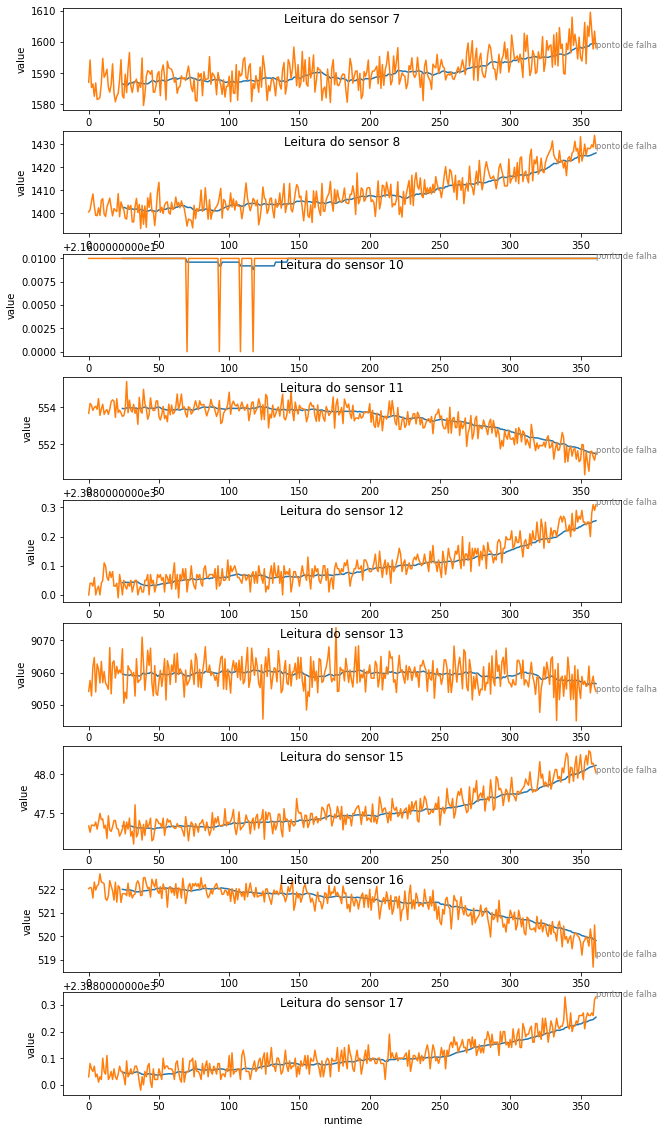

In [71]:
#Visualiza comportamento das features para o  ID com maior runtime

id_69 = df_train[df_train.asset_id==69].values
series_69 = pd.DataFrame(id_69)
groups = [5, 6, 7, 8, 9, 10, 11, 12, 13]
i = 1
plt.figure(figsize=(10,20))

for group in groups:
 plt.subplot(len(groups), 1, i)
 Media_Movel = series_69[group].rolling(25).mean()
 plt.plot(Media_Movel)
 plt.plot(id_69[:, group])
 plt.title(f'Leitura do sensor {df_train.columns[group]}', loc='center',y=0.8,)
 plt.text(series_69.index[-1] ,series_69[group].tail(1) , 'ponto de falha', color='gray', size='small', horizontalalignment='left')
 plt.xlabel('runtime')
 plt.ylabel('value') 
 i += 1
plt.show()

O ID com menor runtime apresenta variações significativas na leitura dos sensores em um periodo de tempo curto, como pode ser visto na sequencia:

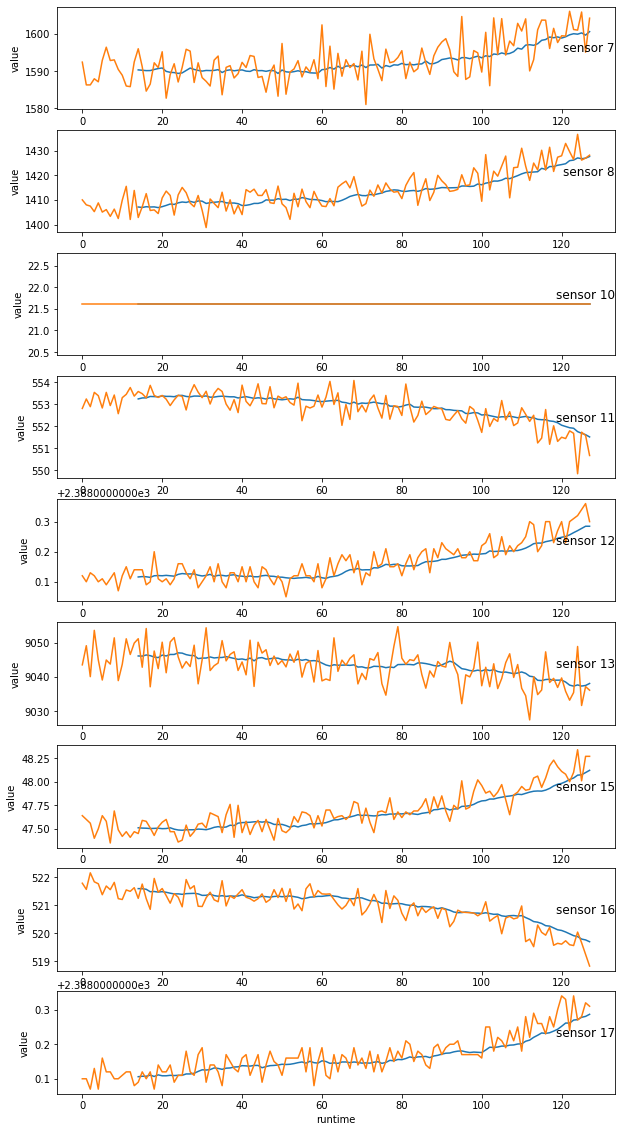

In [45]:
#Visualiza comportamento das features para o  ID com menor runtime

id_39 = df_train[df_train.asset_id==39].values
series_39 = pd.DataFrame(id_39)
groups = [5, 6, 7, 8, 9, 10, 11, 12, 13]
i = 1
plt.figure(figsize=(10,20))
for group in groups:
 plt.subplot(len(groups), 1, i)
 Media_Movel = series_39[group].rolling(15).mean()
 plt.plot(Media_Movel)
 plt.plot(id_39[:, group])
 plt.title(f'sensor {df_train.columns[group]}', y=0.5, loc='right')
 plt.xlabel('runtime')
 plt.ylabel('value')
 i += 1
plt.show()

A leitura do sensor de um ID com valor de runtime mediano mostra que as variações bruscas nos sensores indicam que uma falha está prestes a ocorrer. Essa inclinação se prolonga por aproximadamente 50 runtimes, sendo um alerta de que talvez haja a possibilidade de prever a falha com 20 runtimes de antecedencia.

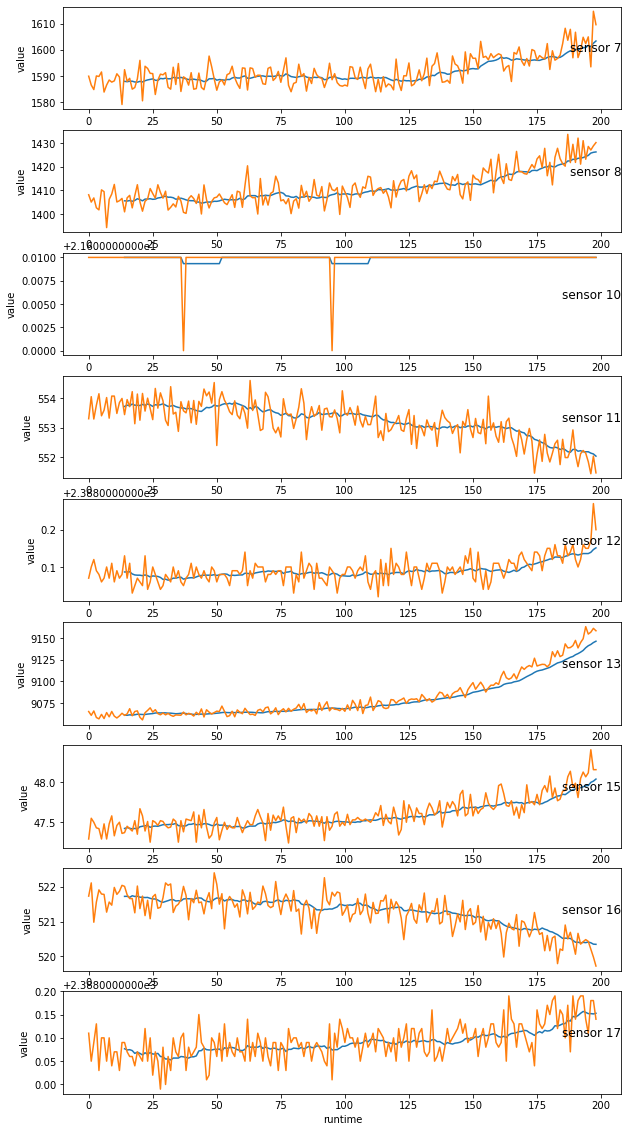

In [47]:
#Visualiza comportamento das features para um ID com runtime mediano

id_68 = df_train[df_train.asset_id==68].values
series_68 = pd.DataFrame(id_68)
groups = [5, 6, 7, 8, 9, 10, 11, 12, 13]
i = 1
plt.figure(figsize=(10,20))
for group in groups:
 plt.subplot(len(groups), 1, i)
 Media_Movel = series_68[group].rolling(15).mean()
 plt.plot(Media_Movel)
 plt.plot(id_68[:, group])
 plt.title(f'sensor {df_train.columns[group]}', y=0.5, loc='right')
 plt.xlabel('runtime')
 plt.ylabel('value')
 i += 1
plt.show()

Com o indicativo anterior, será iniciada a criação de um indicador para o tempo estimado de vida, que será abreviado como RUL (remaining useful life)

In [17]:
# Gerando Coluna com RUL
rul = pd.DataFrame(df_train.groupby('asset_id')['runtime'].max()).reset_index()
rul.columns = ['asset_id', 'max']
train_df = df_train.merge(rul, on=['asset_id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['runtime']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

rul_test = pd.DataFrame(df_test.groupby('asset_id')['runtime'].max()).reset_index()
rul_test.columns = ['asset_id', 'max']
test_df = df_test.merge(rul_test, on=['asset_id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['runtime']
test_df.drop('max', axis=1, inplace=True)

Foi criado um marcador para 20 runtimes conforme solicitado:

In [18]:
# Gerando label para treinamento com previsão em 20 ciclos de antecedência
tempo_previsao = 20

# Label1 indica que uma falha vai ocorrer nos próximos 20 ciclos.
label1 = []
for i in train_df['RUL']:
    if i > tempo_previsao:
        label1.append(0) #saude
    if i == tempo_previsao:
        label1.append(1) #alerta
    if i < tempo_previsao:
        label1.append(2) #falha

train_df['label1'] = label1
train_df.head()

,asset_id,runtime,setting_1,setting_2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,RUL,label1
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0


Em seguida gerado um filtro para os dados que estão prestes a falhar (menos de 20 dias para ocorrer a falha)

In [19]:
#Gerando filtro para alerta
alerta = train_df['label1'] == 1
alerta_df = train_df[alerta]

In [20]:
pred_alerta = alerta_df[['asset_id','runtime','RUL','label1']]

In [21]:
pred_alerta.shape

(100, 4)

In [22]:
#pred_alerta.to_csv(r'pred_alerta.csv')

In [23]:
#Gerando filtro para falha
falha = train_df['label1'] == 2
train_df[falha]

,asset_id,runtime,setting_1,setting_2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,RUL,label1
172,1,173,-0.0032,0.0002,642.97,1590.69,1425.27,21.61,552.13,2388.22,...,47.90,520.11,2388.23,8121.64,8.5091,395,38.59,23.1789,19,2
173,1,174,-0.0001,-0.0002,642.64,1599.81,1422.58,21.61,552.32,2388.22,...,48.00,520.22,2388.21,8119.17,8.4476,393,38.57,23.0357,18,2
174,1,175,0.0001,0.0002,643.61,1603.29,1422.52,21.61,551.64,2388.23,...,47.86,520.38,2388.22,8125.76,8.4890,394,38.58,23.1573,17,2
175,1,176,-0.0020,-0.0003,642.86,1592.27,1422.73,21.61,551.91,2388.23,...,47.84,519.80,2388.20,8123.80,8.4853,394,38.72,23.2491,16,2
176,1,177,-0.0038,-0.0003,643.79,1602.02,1423.99,21.61,551.93,2388.25,...,48.03,520.24,2388.23,8120.11,8.4779,396,38.63,23.1673,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,...,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,2
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,...,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,2
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,...,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,...,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,2


Criado um dataframe somente com os dados anteriores aos 20 runtimes da falha:

In [24]:
#gerando dataframe apenas com dados saudáveis
saude = train_df['label1'] == 0
df_saude = train_df[saude]

df_saude

,asset_id,runtime,setting_1,setting_2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,RUL,label1
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20605,100,175,-0.0013,-0.0005,642.85,1602.03,1416.24,21.61,551.81,2388.23,...,47.69,521.17,2388.17,8140.88,8.4851,394,38.54,23.0713,25,0
20606,100,176,-0.0017,-0.0003,643.33,1601.44,1421.40,21.61,552.69,2388.18,...,47.88,520.76,2388.19,8139.27,8.4405,396,38.46,23.1020,24,0
20607,100,177,-0.0011,-0.0005,643.34,1593.22,1418.91,21.61,552.70,2388.15,...,48.09,520.28,2388.18,8142.95,8.5133,395,38.60,23.0352,23,0
20608,100,178,0.0005,-0.0003,642.98,1594.80,1422.69,21.61,551.86,2388.18,...,47.92,519.81,2388.16,8141.85,8.4876,395,38.55,23.2252,22,0


Com esse dataframe é possível coletar o valor máximo de runtime que o equipamento deve ser utilizado antes de realizar a manutenção:

In [25]:
from sklearn.ensemble import RandomForestClassifier

y = train_df['label1']
X = train_df.drop('label1', axis=1)
clf = RandomForestClassifier(max_depth=5, random_state=0, n_jobs = 10)

clf.fit(X, y)

C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestClassifier(max_depth=5, n_jobs=10, random_state=0)

In [26]:
test_df['pred'] = clf.predict(test_df)
#test_df[['Proba_0','Proba_1','Proba_2']] = clf.predict_proba(test_df)

C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [27]:
#Gerando filtro para proba alerta
#proba_1 = test_df['Proba_1'] > 0.5
#test_df[proba_1]

In [28]:
#Gerando filtro para alerta
alerta_test = test_df['pred'] == 1
test_df[alerta_test]

,asset_id,runtime,setting_1,setting_2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,RUL,pred
10,1,11,0.0007,-0.0004,642.04,1581.03,1403.83,21.61,554.69,2388.04,...,47.23,521.95,2388.06,8132.38,8.3919,391,39.06,23.3609,20,1
59,2,29,-0.0015,-0.0004,642.43,1581.85,1401.94,21.61,553.82,2388.10,...,47.37,521.15,2388.12,8124.70,8.4347,394,39.00,23.3035,20,1
185,3,106,0.0024,0.0000,643.21,1589.98,1414.60,21.61,552.85,2388.11,...,47.75,521.10,2388.10,8128.37,8.4485,393,39.07,23.2566,20,1
291,4,86,-0.0003,-0.0003,642.73,1591.83,1412.46,21.61,553.88,2388.10,...,47.63,521.40,2388.10,8137.14,8.4346,392,38.94,23.2294,20,1
389,5,78,-0.0024,-0.0004,642.40,1588.24,1408.74,21.61,552.78,2388.09,...,47.58,521.62,2388.14,8129.95,8.4237,392,38.97,23.1936,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12525,96,77,0.0024,0.0003,642.40,1584.80,1395.95,21.61,554.45,2388.03,...,47.43,522.31,2388.05,8143.70,8.3978,392,38.89,23.3447,20,1
12659,97,114,-0.0022,0.0002,641.94,1587.41,1404.38,21.61,554.32,2387.98,...,47.34,521.36,2388.02,8149.64,8.4421,392,38.99,23.4091,20,1
12780,98,101,-0.0007,0.0004,642.65,1592.75,1413.82,21.61,553.81,2388.12,...,47.47,521.59,2388.16,8137.27,8.4612,393,38.78,23.3431,20,1
12877,99,77,-0.0002,0.0001,642.09,1586.20,1405.71,21.61,555.22,2387.98,...,47.28,522.40,2388.00,8148.86,8.4106,392,39.10,23.3900,20,1


In [29]:
test_df[alerta_test].nunique()

asset_id     96
runtime      77
setting_1    57
setting_2    12
6            69
7            95
8            95
10            2
11           78
12           24
13           94
15           57
16           76
17           23
18           95
19           93
21            7
24           45
25           95
RUL           1
pred          1
dtype: int64

In [30]:
#Gerando filtro para falha
falha_test = test_df['pred'] == 2
test_df[falha_test]

,asset_id,runtime,setting_1,setting_2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,RUL,pred
11,1,12,0.0026,0.0003,642.54,1587.43,1397.82,21.61,554.35,2388.02,...,47.27,522.01,2388.06,8132.33,8.3984,391,39.11,23.3845,19,2
12,1,13,-0.0056,0.0003,641.94,1589.09,1403.94,21.61,554.04,2388.02,...,47.35,522.37,2388.03,8131.12,8.4166,392,39.08,23.3677,18,2
13,1,14,0.0017,-0.0004,642.23,1583.16,1402.88,21.61,554.66,2388.03,...,47.24,521.95,2388.06,8130.30,8.4293,392,39.03,23.4572,17,2
14,1,15,-0.0003,-0.0003,642.50,1584.81,1398.79,21.61,554.15,2388.00,...,47.35,521.38,2388.00,8133.62,8.4163,392,39.04,23.3672,16,2
15,1,16,-0.0018,0.0003,642.32,1584.51,1407.76,21.61,553.82,2388.10,...,47.39,522.16,2388.10,8133.83,8.4300,390,38.87,23.3484,15,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,...,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,4,2
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,...,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,3,2
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,...,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,2,2
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,...,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,1,2


In [31]:
#gerando dataframe apenas com dados saudáveis
pred_saude = test_df['pred'] == 0
rul_pred = test_df[pred_saude]

#Gerando lista com valores de runtime máximo
maxruntime = []
for id in rul_pred['asset_id'].unique():
    df_id = rul_pred[rul_pred['asset_id'] == id]
    maxruntime.append(df_id['runtime'].max())

id_unico = rul_pred['asset_id'].unique()

#Gerando dataframe com valores de runtime máximo para cada ID
rul_pred = pd.DataFrame(list(zip(id_unico,maxruntime)), columns = ['id','maxruntime'])
rul_pred

,id,maxruntime
0,1,10
1,2,28
2,3,105
3,4,85
4,5,77
...,...,...
95,96,76
96,97,113
97,98,100
98,99,76


In [32]:
rul_pred.to_csv(r'test_pred.csv')

Com isso, é possível verificar o valor mínimo de runtime as máquinas podem ser utilizadas com segurança, sendo utilizado pela equipe de manutenção como momento de alerta para iniciar monitoramentos mais frequentes dos equipamentos.

In [33]:
#df_id_maxruntime['maxruntime'].min()

Em seguida é realizada a limpeza dos dados para iniciar o treinamento de modelos preditivos, retirando as variáveis que não serão utilizadas pelo modelo

In [34]:
# Realizando limpeza do target
print(train_with_target.shape)
leakage_to_drop = ['asset_id']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)

(20631, 20)
(20631, 19)


In [35]:
# Definindo features e variável target 
y = train_with_target['RUL']
X = train_with_target.drop(['RUL'], axis = 1)

In [36]:
# Foi utilizada uma floresta aleatória simples para determinar as features mais importantes para o modelo preditivo.
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15, n_jobs = 10 )
single_rf.fit(X, y)
y_pred_RFR = single_rf.predict(X)
print("complete")

C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


complete


In [37]:
y_pred_RFR.shape

(20631,)

In [38]:
y_pred_RFR

array([187.0091744 , 181.44157541, 185.9690843 , ...,   3.89713626,
         2.16688308,   1.20513344])

In [39]:
train_pred = train_with_target.copy()
train_pred['RUL_pred'] = y_pred_RFR

In [40]:
train_pred.head(200)

,asset_id,runtime,setting_1,setting_2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,RUL,RUL_pred
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,187.009174
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,181.441575
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,185.969084
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,192.837256
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,181.302093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2,4,0.0035,-0.0004,641.68,1584.15,1396.08,21.61,554.25,2387.98,...,47.10,522.49,2387.93,8140.44,8.4018,391,39.13,23.5027,283,280.672044
196,2,5,0.0005,0.0004,641.73,1579.03,1402.52,21.60,555.12,2388.03,...,47.25,522.27,2387.94,8136.67,8.3867,390,39.18,23.4234,282,265.650631
197,2,6,-0.0010,0.0004,641.30,1577.50,1396.76,21.61,554.98,2388.04,...,47.05,522.80,2387.99,8133.65,8.3800,392,39.15,23.4270,281,272.352663
198,2,7,0.0001,-0.0002,642.03,1587.49,1400.65,21.61,554.84,2388.05,...,47.10,522.14,2388.04,8136.33,8.3941,391,39.10,23.4718,280,259.713200


In [41]:
id_1 = train_pred['asset_id'] == 1
pred_id_1 = train_pred[id_1]
pred_id_1


,asset_id,runtime,setting_1,setting_2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,RUL,RUL_pred
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,187.009174
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,181.441575
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,185.969084
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,192.837256
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,181.302093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,643.75,1602.38,1422.78,21.61,551.94,2388.31,...,48.00,519.79,2388.23,8117.69,8.5207,396,38.51,22.9588,4,5.798774
188,1,189,-0.0006,0.0002,644.18,1596.17,1428.01,21.61,550.70,2388.27,...,48.08,519.58,2388.33,8117.51,8.5183,395,38.48,23.1127,3,3.480817
189,1,190,-0.0027,0.0001,643.64,1599.22,1425.95,21.61,551.29,2388.29,...,48.33,520.04,2388.35,8112.58,8.5223,398,38.49,23.0675,2,3.337524
190,1,191,-0.0000,-0.0004,643.34,1602.36,1425.77,21.61,550.92,2388.28,...,48.15,519.57,2388.30,8114.61,8.5174,394,38.45,23.1295,1,2.925998


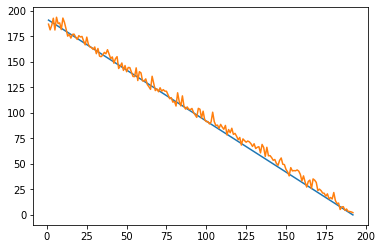

In [42]:
x_coordinates = pred_id_1['runtime']

y1_coordinates = pred_id_1['RUL']
y2_coordinates = pred_id_1['RUL_pred']

plt.plot(x_coordinates, y1_coordinates) # plot first line
plt.plot(x_coordinates, y2_coordinates) # plot second line

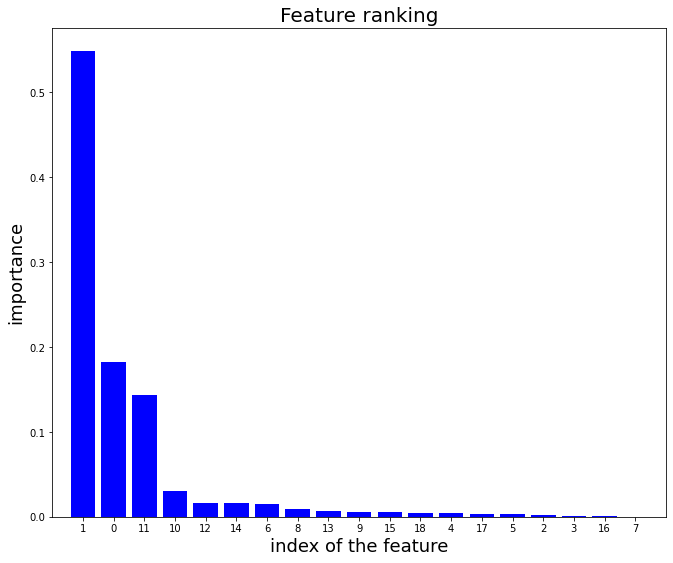

In [43]:
# Gráfico com ranking de features exibindo maior importancia

importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

In [44]:
# Lista features em ordem de importancia
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

runtime      0.548734
asset_id     0.182369
15           0.142979
13           0.030708
16           0.016325
18           0.015908
8            0.014943
11           0.009040
17           0.006353
12           0.005937
19           0.005662
25           0.005042
6            0.003955
24           0.003589
7            0.003447
setting_1    0.002345
setting_2    0.001442
21           0.001140
10           0.000082
dtype: float64


Com o gráfico anterior foi possível verificar que a coluna do sensor de indice 10 tem grande importância na definição do RUL, enquanto o de índice 6 é pouco relevante, portanto pode até mesmo ser excluído da análise

In [45]:
# Baseado nos gráficos e no random forest feature importance, serão excluidas colunas sem muita informação útil
print(train_no_leakage.shape)
vars_to_drop = [10,21,'setting_2',17]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
print(train_final.shape)

(20631, 19)
(20631, 15)


In [46]:
train_final.head()

,runtime,setting_1,6,7,8,11,12,13,15,16,18,19,24,25,RUL
0,1,-0.0007,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,8138.62,8.4195,39.06,23.4190,191
1,2,0.0019,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,8131.49,8.4318,39.00,23.4236,190
2,3,-0.0043,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,8133.23,8.4178,38.95,23.3442,189
3,4,0.0007,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,8133.83,8.3682,38.88,23.3739,188
4,5,-0.0019,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,8133.80,8.4294,38.90,23.4044,187


In [47]:
# Identifica variáveis categóricas e numéricas
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)

# Cria variáveis dummy (se houver alguma variável categórica)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
    
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['RUL']
X = numeric.drop(['RUL'], axis = 1)

[]
runtime
setting_1
6
7
8
11
12
13
15
16
18
19
24
25
RUL


In [48]:
# random forest regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Modelo escolhido
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()

# Configurado para 5 validações cruzadas
from sklearn import model_selection
cv = model_selection.KFold(5)

# Normalização e definição do modelo no pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])

# Ajuste do modelo
my_min_samples_leaf = [2, 10, 25]
my_max_depth = [5, 7, 9, 11]

In [ ]:
# Roda o modelo usando gridsearch, seleciona o modelo com melhor search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline, 
                            cv=cv,
                            param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth), 
                            scoring = 'neg_mean_squared_error', 
                            verbose = 1, 
                            n_jobs = -1
                            )
optimized_rf.fit(X_train, y_train)


In [ ]:
# Printa o melhor estimador do modelo
print(optimized_rf.best_estimator_)

Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=11, min_samples_leaf=10))])


In [ ]:
# Avalia métricas do modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_RFM = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred_RFM))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred_RFM))
print("Random Forest r-squared: ", r2_score(y_test, y_pred_RFM))

Random Forest Mean Squared Error:  1305.8966348644492
Random Forest Mean Absolute Error:  25.550283677097745
Random Forest r-squared:  0.723688732847762


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
y_pred_RFM.shape

(4127,)

In [ ]:
X_test.shape

(4127, 14)

In [ ]:
y_pred_RFM

array([176.56595199,  42.21597093, 157.34293935, ..., 141.35345598,
        86.17230721,  99.66227633])

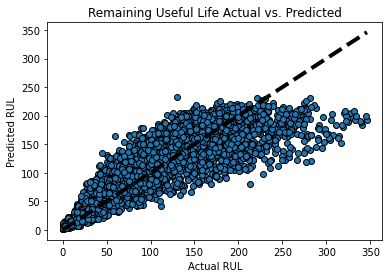

In [ ]:
# Plota atual vs predito Remaining Useful Life para o melhor modelo (RFM)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_RFM, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [ ]:
# Elastic Net GLM
# 
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# escolha do modelo
from sklearn.linear_model import ElasticNet
glm_net = ElasticNet()

#  Configurado para 5 validações cruzadas
from sklearn import model_selection
cv = model_selection.KFold(5)
# Normalização e definição do modelo no pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', glm_net) ])
# Ajuste do modelo
my_alpha = np.linspace(.01, 1, num=5)
my_l1_ratio = np.linspace(.01, 1, num=3)
# Roda o modelo usando gridsearch (ferramenta para automatizar o ajuste dos parâmetros), seleciona o modelo com melhor search
from sklearn.model_selection import GridSearchCV
optimized_glm_net = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__l1_ratio = my_l1_ratio, model__alpha = my_alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = 10
                           )
optimized_glm_net.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardize', StandardScaler()),
                                       ('model', ElasticNet())]),
             n_jobs=-1,
             param_grid={'model__alpha': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                         'model__l1_ratio': array([0.01 , 0.505, 1.   ])},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# Printa os melhores estimadores
print(optimized_glm_net.best_estimator_)

# avalia as metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_GLM = optimized_glm_net.predict(X_test)
print("GLM Elastic Net Mean Squared Error: ", mean_squared_error(y_test, y_pred_GLM))
print("GLM Elastic Net Mean Absolute Error: ", mean_absolute_error(y_test, y_pred_GLM))
print("GLM Elastic Net r-squared: ", r2_score(y_test, y_pred_GLM))

Pipeline(steps=[('standardize', StandardScaler()),
                ('model', ElasticNet(alpha=0.01, l1_ratio=0.01))])
GLM Elastic Net Mean Squared Error:  1660.2297837960998
GLM Elastic Net Mean Absolute Error:  31.317068707180102
GLM Elastic Net r-squared:  0.6487163048917701


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
y_pred_GLM.shape

(4127,)

In [ ]:
y_pred_GLM

array([170.85015829,  63.0665675 , 167.88107941, ..., 154.35653394,
        96.81998035,  73.75924236])

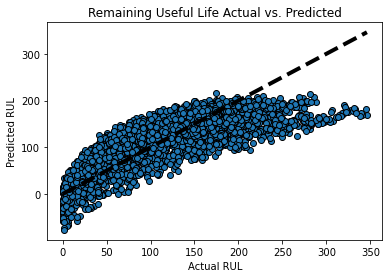

In [ ]:
# Plota atual vs predito Remaining Useful Life para o melhor modelo (GLM)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_GLM, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [ ]:
# Support Vector Machines
# 
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

from sklearn import svm
from sklearn.svm import SVR
svm = svm.SVR()

from sklearn import model_selection
cv = model_selection.KFold(5)

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', svm) ])

my_C = [1]
my_epsilon = [.05, .1, .15]

from sklearn.model_selection import GridSearchCV
optimized_svm = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__C = my_C, model__epsilon = my_epsilon)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_svm.fit(X_train, y_train)

print(optimized_svm.best_estimator_)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_svm = optimized_svm.predict(X_test)
print("SVM Mean Squared Error: ", mean_squared_error(y_test, y_pred_svm))
print("SVM Mean Absolute Error: ", mean_absolute_error(y_test, y_pred_svm))
print("SVM r-squared: ", r2_score(y_test, y_pred_svm))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Pipeline(steps=[('standardize', StandardScaler()),
                ('model', SVR(C=1, epsilon=0.05))])


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


SVM Mean Squared Error:  1479.1851691403758
SVM Mean Absolute Error:  26.41181947582223
SVM r-squared:  0.6870230632913767


In [ ]:
y_pred_svm.shape

(4127,)

In [ ]:
y_pred_svm

array([172.13370877,  45.61125621, 153.29356797, ..., 147.39563618,
        86.29041068,  81.44815751])

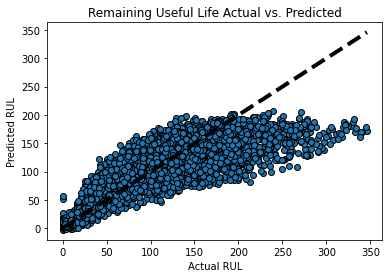

In [ ]:

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_svm, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [ ]:
# Gradient Boosting

import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

from sklearn.ensemble import GradientBoostingRegressor
gb = ensemble.GradientBoostingRegressor()

from sklearn import model_selection
cv = model_selection.KFold(5)

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', gb) ])

my_alpha = [.5, .75, .9]
my_n_estimators= [500]
my_learning_rate = [0.005, .01]
my_max_depth = [4, 5, 6]

from sklearn.model_selection import GridSearchCV
optimized_gb = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__max_depth = my_max_depth, model__n_estimators = my_n_estimators,
                                              model__learning_rate = my_learning_rate, model__alpha = my_alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_gb.fit(X_train, y_train)

print(optimized_gb.best_estimator_)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_gb = optimized_gb.predict(X_test)
print("Gradient Boosting Mean Squared Error: ", mean_squared_error(y_test, y_pred_gb))
print("Gradient Boosting Mean Absolute Error: ", mean_absolute_error(y_test, y_pred_gb))
print("Gradient Boosting r-squared: ", r2_score(y_test, y_pred_gb))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(alpha=0.5, learning_rate=0.01,
                                           max_depth=5, n_estimators=500))])
Gradient Boosting Mean Squared Error:  1300.277492564527
Gradient Boosting Mean Absolute Error:  25.528819245709155
Gradient Boosting r-squared:  0.7248776725293176


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
y_pred_gb.shape
print(y_pred_gb)

[179.15515239  46.15175827 154.82704636 ... 133.47659678  92.78716265
 109.09862336]


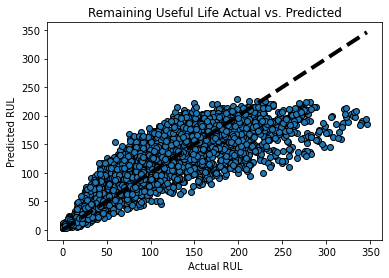

In [ ]:

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_gb, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [ ]:
# Transformando previsão em um resolvedor de classificação
# gera colunas de rótulos para dados de treinamento
cycles = 20
train_no_leakage['Target_20_Cycles'] = np.where(train_no_leakage['RUL'] <= cycles, 1, 0 )
train_no_leakage.tail(5)

,runtime,setting_1,setting_2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25,RUL,Target_20_Cycles
20626,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,1
20627,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,1
20628,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,1
20629,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,1
20630,200,-0.0032,-0.0005,643.85,1600.38,1432.14,21.61,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,396,38.37,23.0522,0,1


In [ ]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = [10,21,12,17,24]
target_to_drop = ['RUL']
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
train_final = train_no_leakage.drop(target_to_drop, axis = 1)
train_final.tail()

(20631, 20)


,runtime,setting_1,setting_2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25,Target_20_Cycles
20626,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,1
20627,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,1
20628,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,1
20629,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1
20630,200,-0.0032,-0.0005,643.85,1600.38,1432.14,21.61,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,396,38.37,23.0522,1


In [ ]:
# identify categorical and numeric fields
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_20_Cycles']
X = numeric.drop(['Target_20_Cycles'], axis = 1)

[]
runtime
setting_1
setting_2
6
7
8
10
11
12
13
15
16
17
18
19
21
24
25
Target_20_Cycles


In [ ]:
# random forest regression
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
rf = ensemble.RandomForestClassifier()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 25, 50]
my_max_depth = [8, 9, 10, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1]
y_pred_rfr = optimized_rf.predict(X_test)
print(optimized_rf.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=2))])


C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\felip\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
type(y_pred_rfr)    

numpy.ndarray

In [ ]:
y_pred_proba

In [ ]:
y_pred_rfr

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
RFR_pred = pd.Series(y_pred_rfr)
RFR_pred.unique()

array([0, 1])

In [ ]:
df_rfr = train_final + train_final['y_pred_rfr']
df_rfr.head()

Confusion Matrix:
[[3679   57]
 [  56  335]]
Random Forest Accuracy: 97.3%
Random Forest Precision: 85.5%
Random Forest Recall: 85.7%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3736
           1       0.85      0.86      0.86       391

    accuracy                           0.97      4127
   macro avg       0.92      0.92      0.92      4127
weighted avg       0.97      0.97      0.97      4127



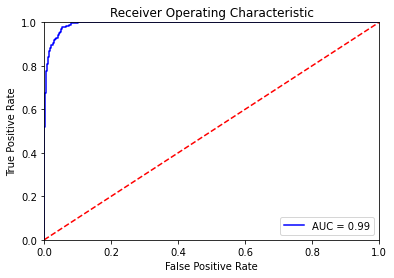

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfr))
from sklearn.metrics import classification_report
print("Random Forest Accuracy: "+"{:.1%}".format(accuracy_score(y_test, y_pred_rfr)));
print("Random Forest Precision: "+"{:.1%}".format(precision_score(y_test, y_pred_rfr)));
print("Random Forest Recall: "+"{:.1%}".format(recall_score(y_test, y_pred_rfr)));
print("Classification Report:")
print(classification_report(y_test, y_pred_rfr))
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
wood_pulp = pd.read_html('http://www.sunsirs.com/uk/prodetail-958.html')
print(f'Total tables: {len(wood_pulp)}')

Total tables: 1


In [ ]:
df_wood = wood_pulp[0]
df_wood

,0,1,2,3
0,Commodity,Sectors,Price,Date
1,Wood pulp,Building materials,6190.00,2022-03-17
2,Wood pulp,Building materials,6180.00,2022-03-16
3,Wood pulp,Building materials,6170.00,2022-03-15
4,Wood pulp,Building materials,6130.00,2022-03-14
5,Wood pulp,Building materials,6130.00,2022-03-13
6,Wood pulp,Building materials,6130.00,2022-03-12


In [ ]:
df_wood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7 non-null      object
 1   1       7 non-null      object
 2   2       7 non-null      object
 3   3       7 non-null      object
dtypes: object(4)
memory usage: 352.0+ bytes
